In [2]:
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import LearningRateScheduler
import os

In [3]:
# Handwritten data set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Text numbers data set
with open('text_x_data.npy', 'rb') as f:
    x_data2 = np.load(f).astype(np.uint8)
    x_data2 = cv2.bitwise_not(x_data2)
with open('text_y_data.npy', 'rb') as f:
    y_data2 = np.load(f)

In [5]:
# Split text data set
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data2, y_data2, test_size=0.14, random_state=42)

In [6]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [7]:
x_train = x_train.reshape((x_train.shape[0],28,28,1))
x_test = x_test.reshape((x_test.shape[0],28,28,1))
y_train = to_categorical(y_train, num_classes = 10)
y_train2 = to_categorical(y_train2, num_classes = 10)

In [8]:
# Join data sets
x_train = np.concatenate((x_train, x_train2))
x_test = np.concatenate((x_test, x_test2))
y_train = np.concatenate((y_train, y_train2))
y_test = np.concatenate((y_test, y_test2))

In [9]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(68737, 28, 28, 1) (11423, 28, 28, 1) (68737, 10) (11423,)


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


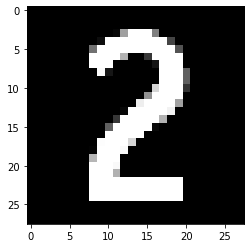

In [10]:
idx = 67000
print(y_train[idx])
# [0 0 1 0 0 0 0 0 0 0] is hot-one representation of 2
plt.imshow(x_train[idx].reshape((28,28)),cmap='gray')

In [ ]:
########
#MODEL BELOW
#########

In [11]:
# GLOBAL VARIABLES
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [12]:
model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(x_train, y_train, test_size = 0.2)
# TRAIN NETWORK
epochs = 10

# history = model.fit(X_train2,Y_train2, batch_size=64, epochs = epochs, validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
# print(f"Epochs={epochs}, Train accuracy={max(history.history['acc'])}, Validation accuracy={max(history.history['val_acc'])}")
    
# CREATE MORE TRAINING IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
# TRAIN NETWORK
history = model.fit(datagen.flow(X_train2,Y_train2, batch_size=64), 
    epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,
    validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)

print(f"Epochs={epochs}, Train accuracy={max(history.history['accuracy'])}, Validation accuracy={max(history.history['val_accuracy'])}")

Epochs=10, Train accuracy=0.9907327890396118, Validation accuracy=0.9950538277626038


In [ ]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

In [ ]:
model.save("../../model/model")